<a href="https://colab.research.google.com/github/balawillgetyou/dy/blob/master/harddisksmartTreesSurvival202100213.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hard disk failure prediction using boosted trees and survival analysis

In [ ]:
#!pip install lifelines

     |████████████████████████████████| 348kB 5.9MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=93c99cfc4cc12117c883f01e13ccad24e79c32cfa8ac93d405db74746e33ea1c
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [ ]:
import numpy as np 
import pandas as pd 
from pandas.plotting import table 

import datetime

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

from numpy import mean
from numpy import std

from lifelines.utils import datetimes_to_durations
from lifelines.utils import survival_table_from_events

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import median_survival_times
from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test, logrank_test



import warnings
warnings.filterwarnings('ignore')

### Data load, explore, pre-process, feature engineering

In [ ]:
# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list -s hard
# !kaggle datasets download -d backblaze/hard-drive-test-data 
# !unzip hard-drive-test-data.zip

Saving kaggle.json to kaggle.json
ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
backblaze/hard-drive-test-data                                 Hard Drive Test Data                                202MB  2016-11-05 05:39:40           3064  
jackywangkaggle/hard-drive-data-and-stats                      Hard Drive Data and Stats                             2GB  2020-02-04 19:32:29            411  
ezeydan/hard-drive-failure-data                                Hard Drive Failure Data                                0B  2019-04-15 14:59:43            490  
delayedkarma/fantasy-premier-league-20182019                   Fantasy Premier League (FPL) 2018-2019              143KB  2018-11-23 22:50:17           2315  
johnsyin97/h

In [ ]:
#data source: https://www.kaggle.com/backblaze/hard-drive-test-data
hDData = pd.read_csv('/content/harddrive.csv')

In [ ]:
hDData['date'] = pd.to_datetime(hDData['date'])
hDData['date']=hDData['date'].dt.date
print(hDData['date'].max())
print(hDData['date'].min())

2016-04-29
2016-01-01


In [ ]:
hDData.shape

(3179295, 95)

In [ ]:
hDData.drop_duplicates(inplace=True)

In [ ]:
hDData.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_8_normalized,smart_8_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_10_raw,smart_11_normalized,smart_11_raw,smart_12_normalized,smart_12_raw,smart_13_normalized,smart_13_raw,smart_15_normalized,smart_15_raw,smart_22_normalized,smart_22_raw,smart_183_normalized,smart_183_raw,smart_184_normalized,smart_184_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,...,smart_196_normalized,smart_196_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_200_normalized,smart_200_raw,smart_201_normalized,smart_201_raw,smart_220_normalized,smart_220_raw,smart_222_normalized,smart_222_raw,smart_223_normalized,smart_223_raw,smart_224_normalized,smart_224_raw,smart_225_normalized,smart_225_raw,smart_226_normalized,smart_226_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,108.0,143,540,100,14,100,0,100,0.000000e+00,122.0,37.0,97,27929,100,0,NaN,NaN,100,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,0.0,100,0,100,0,200,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,NaN,96,0,100,4,100,0,63,1.279800e-317,NaN,NaN,100,411,100,0,NaN,NaN,100,4,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,100.0,0.0,100.0,0.0,100.0,...,NaN,NaN,100,0,100,0,200,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,1.319155e-321,100.0,3.467963e-315,100.0,1.316882e-315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,124,566,100,19,100,0,100,0.000000e+00,122.0,37.0,97,27492,100,0,NaN,NaN,100,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,0.0,100,0,100,0,200,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,137,507,100,15,100,0,100,0.000000e+00,122.0,37.0,97,26640,100,0,NaN,NaN,100,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,0.0,100,0,100,0,200,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,NaN,175,6250,100,10,200,0,100,0.000000e+00,NaN,NaN,84,12198,100,0,100.0,0.0,100,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,200.0,0.0,200,0,100,0,200,0,100.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
hDData.shape

(3058798, 95)

In [ ]:
#extracting models with failures for analysis
hDDataModelValCounts = hDData.model.value_counts()
hDDataModelValCounts = pd.DataFrame(hDDataModelValCounts).reset_index()
hDDataModelValCounts.columns = ['model', 'modelCount']
hDDataFailByModelCounts = hDData[hDData['failure'] == 1].groupby('model')['failure'].count()
hDDataFailByModelProp = pd.merge(hDDataModelValCounts.reset_index(), hDDataFailByModelCounts.reset_index(), on = 'model')
hDDataFailByModelProp['failPercent'] = (hDDataFailByModelProp['failure']/hDDataFailByModelProp['modelCount'])*100
hDDataFailByModelProp.sort_values('failPercent', ascending = False,inplace=True)
hDDataFailByModelProp[:10]

,index,model,modelCount,failure,failPercent
24,59,WDC WD3200BEKT,30,1,3.333333
22,40,WDC WD1600AAJB,185,2,1.081081
19,31,WDC WD800AAJS,680,6,0.882353
23,44,WDC WD800BB,132,1,0.757576
13,19,ST320LT007,2578,15,0.581846
21,39,WDC WD800AAJB,190,1,0.526316
20,32,WDC WD3200BEKX,513,1,0.194932
18,28,WDC WD10EADS,1342,2,0.149031
17,25,ST3160318AS,2209,2,0.090539
16,24,TOSHIBA MD04ABA500V,2250,1,0.044444


In [ ]:
tempFile = hDDataFailByModelProp[['model','modelCount','failure', 'failPercent']]
tempFile.drop_duplicates(inplace=True)
tempFile.columns = ['model','# of observations','# of failures', 'failPercent']
tempFile.sort_values('failPercent')


,model,# of observations,# of failures,failPercent
4,HGST HMS5C4040BLE640,180650,1,0.000554
1,HGST HMS5C4040ALE640,353917,2,0.000565
6,ST6000DX000,94100,2,0.002125
2,Hitachi HDS5C3030ALA630,227580,5,0.002197
5,Hitachi HDS5C4040ALE630,131698,3,0.002278
8,WDC WD60EFRX,22900,1,0.004367
3,Hitachi HDS722020ALA330,215300,13,0.006038
0,ST4000DM000,1617720,131,0.008098
7,WDC WD30EFRX,52586,6,0.011410
9,ST4000DX000,10428,2,0.019179


In [ ]:
print(len(hDDataFailByModelProp.model.unique()))
hDDataFailByModelProp.model.unique()

25


array(['WDC WD3200BEKT', 'WDC WD1600AAJB', 'WDC WD800AAJS', 'WDC WD800BB',
       'ST320LT007', 'WDC WD800AAJB', 'WDC WD3200BEKX', 'WDC WD10EADS',
       'ST3160318AS', 'TOSHIBA MD04ABA500V', 'TOSHIBA DT01ACA300',
       'ST3160316AS', 'WDC WD1600AAJS', 'ST9250315AS', 'WDC WD20EFRX',
       'ST4000DX000', 'WDC WD30EFRX', 'ST4000DM000',
       'Hitachi HDS722020ALA330', 'WDC WD60EFRX',
       'Hitachi HDS5C4040ALE630', 'Hitachi HDS5C3030ALA630',
       'ST6000DX000', 'HGST HMS5C4040ALE640', 'HGST HMS5C4040BLE640'],
      dtype=object)

In [ ]:
#trimming the dataset - IMPORTANT: devices 'serial_number' that have never failed are also included 
modelList = hDData['model'][hDData['failure']==1].value_counts().sort_values(ascending=False)[:25]
df = hDData[hDData['model'].isin(hDDataFailByModelProp['model'][:25])]
print('Updated dataset shape',df.shape)
print('Some of the devices, in the trimmed dataset, that have never failed')
df['serial_number'][df['failure']==0].value_counts().sort_values(ascending=False)[:25]


Updated dataset shape (2935708, 95)
Some of the devices, in the trimmed dataset, that have never failed


WD-WMC1T0842843    50
Z3025KRY           50
Z3025LGH           50
Z300ZV6D           50
PL2331LAGN2MAJ     50
PL1331LAGSJHSH     50
Z3015GTC           50
W30096S2           50
MJ1311YNG3490A     50
Z300GPZD           50
PL1331LAGRDZAH     50
PL2331LAGULLNJ     50
PL1331LAGR6LGH     50
W300C62A           50
MJ0351YNGA0ASA     50
S301K9ZG           50
S300YCHC           50
PL1331LAGS4DWH     50
W300CG83           50
Z300PLZQ           50
Z3015XVD           50
JK11A8B9J3UN9F     50
PL2331LAGMSGNJ     50
PL1331LAGRZRKH     50
PL2331LAGSU0AJ     50
Name: serial_number, dtype: int64

In [ ]:
# #devices are added and removed from the dataset, with or without failure. It's unclear why the the same 'serial_number' and 'date' appear more than once.
# #in any case, the following code slices out device survival during the various intervals recorded

# #https://stackoverflow.com/questions/53305411/how-to-find-gaps-in-dates-using-pandas
# # Convert date to true dates
# df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
# df['date'] = df['date'].dt.date
# grp = df.groupby(by='serial_number')
# # Starts of periods
# st = grp.apply(lambda x: x.date[x.date - pd.DateOffset(days = 1)
#     != x.date.shift()]).reset_index(level=1,drop=True)
# print('st done')
# # Ends of periods
# en = grp.apply(lambda x: x.date[x.date + pd.DateOffset(days = 1)
#     != x.date.shift(-1)]).reset_index(level=1,drop=True)
# print('en done')

# # Result - concat start / end dates
# res = pd.concat([st, en], axis=1).reset_index()

# print('concat done')

# # Set column names
# res.columns = ['serial_number', 'start', 'end']
# res
# res.to_csv('/content/res.csv')
res = pd.read_csv('/content/res.csv')

In [ ]:
res.shape

(117960, 4)

In [ ]:
#adding back the details needed
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
res.start = pd.to_datetime(res.start, format='%Y-%m-%d')
res.end = pd.to_datetime(res.end, format='%Y-%m-%d')

df1 = pd.merge(res,df[['model','serial_number','failure','date']], left_on=['serial_number','end'],right_on=['serial_number','date'], how='left').drop(['date'], axis='columns')
df1['duration'] = df1['end']-df1['start']
df1['duration'] = df1.duration.dt.days
print(df1['end'].max())
print(df1['end'].min())
df1.drop_duplicates()

2016-04-29 00:00:00
2016-01-01 00:00:00


,Unnamed: 0,serial_number,start,end,model,failure,duration
0,0,13H2B97AS,2016-01-01,2016-01-21,TOSHIBA DT01ACA300,0,20
1,1,13H2B97AS,2016-04-01,2016-04-29,TOSHIBA DT01ACA300,0,28
2,2,13H32WEAS,2016-01-01,2016-01-21,TOSHIBA DT01ACA300,0,20
3,3,13H32WEAS,2016-04-01,2016-04-29,TOSHIBA DT01ACA300,0,28
4,4,13H6A21GS,2016-01-01,2016-01-21,TOSHIBA DT01ACA300,0,20
...,...,...,...,...,...,...,...
117955,117955,Z4D1XY09,2016-04-01,2016-04-29,ST6000DX000,0,28
117956,117956,Z4D29XNF,2016-01-01,2016-01-21,ST6000DX000,0,20
117957,117957,Z4D29XNF,2016-04-01,2016-04-29,ST6000DX000,0,28
117958,117958,Z4D2B5EC,2016-01-01,2016-01-21,ST6000DX000,0,20


In [ ]:
df1.duration.describe()

count    117960.000000
mean         23.887318
std           4.504314
min           0.000000
25%          20.000000
50%          28.000000
75%          28.000000
max          28.000000
Name: duration, dtype: float64

Exploring data size, number of failures, list of models, proportion of failures by model

In [ ]:
topFew = 40

In [ ]:
hDData.model.value_counts()[:topFew]

ST4000DM000                1617720
HGST HMS5C4040ALE640        353917
Hitachi HDS5C3030ALA630     227580
Hitachi HDS722020ALA330     215300
HGST HMS5C4040BLE640        180650
Hitachi HDS5C4040ALE630     131698
ST6000DX000                  94100
WDC WD30EFRX                 52586
Hitachi HDS723030ALA640      49942
ST500LM012 HN                30252
WDC WD60EFRX                 22900
WDC WD5000LPVX               14150
ST4000DX000                  10428
TOSHIBA MD04ABA400V           7279
WDC WD20EFRX                  6606
WDC WD1600AAJS                4805
ST31500541AS                  4161
HGST HDS5C4040ALE630          3481
ST9250315AS                   2581
ST320LT007                    2578
ST3160316AS                   2387
TOSHIBA DT01ACA300            2341
WDC WD40EFRX                  2300
HGST HUH728080ALE600          2250
TOSHIBA MD04ABA500V           2250
ST3160318AS                   2209
HGST HDS724040ALE640          2000
ST250LM004 HN                 1619
WDC WD10EADS        

In [ ]:
hDDataModelValCounts = hDData.model.value_counts()
hDDataModelValCounts = pd.DataFrame(hDDataModelValCounts).reset_index()
hDDataModelValCounts.columns = ['model', 'modelCount']
hDDataFailByModelCounts = hDData[hDData['failure'] == 1].groupby('model')['failure'].count()
hDDataFailByModelProp = pd.merge(hDDataModelValCounts.reset_index(), hDDataFailByModelCounts.reset_index(), on = 'model')
hDDataFailByModelProp['failPercent'] = (hDDataFailByModelProp['failure']/hDDataFailByModelProp['modelCount'])*100
hDDataFailByModelProp.sort_values('failPercent', ascending = False,inplace=True)
hDDataFailByModelProp[:topFew]


,index,model,modelCount,failure,failPercent
24,59,WDC WD3200BEKT,30,1,3.333333
22,40,WDC WD1600AAJB,185,2,1.081081
19,31,WDC WD800AAJS,680,6,0.882353
23,44,WDC WD800BB,132,1,0.757576
13,19,ST320LT007,2578,15,0.581846
21,39,WDC WD800AAJB,190,1,0.526316
20,32,WDC WD3200BEKX,513,1,0.194932
18,28,WDC WD10EADS,1342,2,0.149031
17,25,ST3160318AS,2209,2,0.090539
16,24,TOSHIBA MD04ABA500V,2250,1,0.044444


In [ ]:
#hDData1 = hDData[hDData.model.isin(hDData[hDData['failure'] == 1].groupby('model')['failure'].count().sort_values()[-5:].index)]
hDData1 = hDData[hDData.model.isin(hDDataFailByModelProp['model'][:topFew])]
print(hDData1.shape)
print(hDData1.model.unique())

(2935708, 95)
['Hitachi HDS5C3030ALA630' 'ST4000DM000' 'WDC WD30EFRX'
 'Hitachi HDS5C4040ALE630' 'HGST HMS5C4040ALE640' 'HGST HMS5C4040BLE640'
 'ST6000DX000' 'Hitachi HDS722020ALA330' 'ST4000DX000' 'WDC WD60EFRX'
 'WDC WD1600AAJS' 'ST320LT007' 'TOSHIBA MD04ABA500V' 'TOSHIBA DT01ACA300'
 'ST3160318AS' 'WDC WD20EFRX' 'ST9250315AS' 'ST3160316AS' 'WDC WD800AAJS'
 'WDC WD3200BEKX' 'WDC WD1600AAJB' 'WDC WD800AAJB' 'WDC WD3200BEKT'
 'WDC WD800BB' 'WDC WD10EADS']


Feature engineering to extract serial number wise survival duration.

In [ ]:
hDData_dates_event = hDData1.groupby('serial_number').agg({'date': [min,max], 'failure': max})
hDData_dates_event

date             failure
                      min         max     max
serial_number                                
13H2B97AS      2016-01-01  2016-04-29       0
13H32WEAS      2016-01-01  2016-04-29       0
13H6A21GS      2016-01-01  2016-04-29       0
13H7X2HAS      2016-01-01  2016-04-29       0
13H85BMGS      2016-01-01  2016-04-29       0
...                   ...         ...     ...
Z4D1X9LF       2016-01-01  2016-04-29       0
Z4D1XXJX       2016-01-01  2016-04-29       0
Z4D1XY09       2016-01-01  2016-04-29       0
Z4D29XNF       2016-01-01  2016-04-29       0
Z4D2B5EC       2016-01-01  2016-04-29       0

[63197 rows x 3 columns]

In [ ]:
hDData_dates_event.columns = list(map(''.join, hDData_dates_event.columns.values))
print(hDData_dates_event.failuremax.sum())
hDData_dates_event

205


,datemin,datemax,failuremax
serial_number,,,
13H2B97AS,2016-01-01,2016-04-29,0
13H32WEAS,2016-01-01,2016-04-29,0
13H6A21GS,2016-01-01,2016-04-29,0
13H7X2HAS,2016-01-01,2016-04-29,0
13H85BMGS,2016-01-01,2016-04-29,0
...,...,...,...
Z4D1X9LF,2016-01-01,2016-04-29,0
Z4D1XXJX,2016-01-01,2016-04-29,0
Z4D1XY09,2016-01-01,2016-04-29,0


In [ ]:
hDData_dates_event['failDate'] = ""
hDData_dates_event['failDate'] = hDData_dates_event['datemax'][hDData_dates_event['failuremax']==1]
print(hDData_dates_event.shape)
print(hDData_dates_event.head())
print(hDData_dates_event[~pd.isnull(hDData_dates_event.failDate)])
print(hDData_dates_event[~pd.isnull(hDData_dates_event.failDate)].shape)

(63197, 4)
                  datemin     datemax  failuremax failDate
serial_number                                             
13H2B97AS      2016-01-01  2016-04-29           0      NaN
13H32WEAS      2016-01-01  2016-04-29           0      NaN
13H6A21GS      2016-01-01  2016-04-29           0      NaN
13H7X2HAS      2016-01-01  2016-04-29           0      NaN
13H85BMGS      2016-01-01  2016-04-29           0      NaN
                   datemin     datemax  failuremax    failDate
serial_number                                                 
13H883WAS       2016-01-01  2016-04-20           1  2016-04-20
6VMX70TB        2016-01-01  2016-04-04           1  2016-04-04
9VY8TC9H        2016-01-01  2016-04-18           1  2016-04-18
9VY8TCAV        2016-01-01  2016-04-09           1  2016-04-09
JK1101B9GEJEUF  2016-01-01  2016-04-21           1  2016-04-21
...                    ...         ...         ...         ...
Z305GV9E        2016-04-01  2016-04-20           1  2016-04-20
Z305K26M 

In [ ]:
#hDData_dates_event.reset_index()
hDData_dates_event1 = pd.merge(hDData_dates_event.reset_index(), hDData[['model','serial_number']], on='serial_number', how='left')
print(hDData_dates_event1.head())
print(hDData_dates_event1.shape)
hDData_dates_event1.drop_duplicates(inplace=True)
print(hDData_dates_event1.head())
print(hDData_dates_event1.shape)
print(hDData_dates_event1.failuremax.sum())


  serial_number     datemin  ... failDate               model
0     13H2B97AS  2016-01-01  ...      NaN  TOSHIBA DT01ACA300
1     13H2B97AS  2016-01-01  ...      NaN  TOSHIBA DT01ACA300
2     13H2B97AS  2016-01-01  ...      NaN  TOSHIBA DT01ACA300
3     13H2B97AS  2016-01-01  ...      NaN  TOSHIBA DT01ACA300
4     13H2B97AS  2016-01-01  ...      NaN  TOSHIBA DT01ACA300

[5 rows x 6 columns]
(2935708, 6)
    serial_number     datemin  ... failDate               model
0       13H2B97AS  2016-01-01  ...      NaN  TOSHIBA DT01ACA300
50      13H32WEAS  2016-01-01  ...      NaN  TOSHIBA DT01ACA300
100     13H6A21GS  2016-01-01  ...      NaN  TOSHIBA DT01ACA300
150     13H7X2HAS  2016-01-01  ...      NaN  TOSHIBA DT01ACA300
200     13H85BMGS  2016-01-01  ...      NaN  TOSHIBA DT01ACA300

[5 rows x 6 columns]
(63197, 6)
205


## Temporal analysis

Note the creation of features 'RUL' and 'FIW' that represent time to failure

In [ ]:
hDData_failures = hDData_dates_event[~pd.isnull(hDData_dates_event.failDate)]
hDData_failures['failDate'] = pd.to_datetime(hDData_failures['failDate'])
hDData_failures['datemin'] = pd.to_datetime(hDData_failures['datemin'])
hDData_failures['duration'] = hDData_failures['failDate']-hDData_failures['datemin']
hDData_failures.reset_index(inplace = True)
hDData_failures.tail()

,serial_number,datemin,datemax,failuremax,failDate,duration
200,Z305GV9E,2016-04-01,2016-04-20,1,2016-04-20,19 days
201,Z305K26M,2016-04-01,2016-04-20,1,2016-04-20,19 days
202,Z305LZGQ,2016-04-01,2016-04-19,1,2016-04-19,18 days
203,Z4D045CF,2016-01-01,2016-04-05,1,2016-04-05,95 days
204,Z4D04BH9,2016-01-01,2016-04-05,1,2016-04-05,95 days


In [ ]:
hDData_failures_data = hDData.merge(hDData_failures, on = ['serial_number'], how='inner').dropna(axis='columns', how='any')
hDData_failures_data['date'] = pd.to_datetime(hDData_failures_data['date'])
hDData_failures_data ['RUL'] = hDData_failures_data['failDate'] - hDData_failures_data['date']
hDData_failures_data ['RUL'] = hDData_failures_data.RUL.dt.days


In [ ]:
hDData_failures_data.shape

(5174, 39)

In [ ]:
hDData_failures_data.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_1_normalized', 'smart_1_raw', 'smart_3_normalized',
       'smart_3_raw', 'smart_4_normalized', 'smart_4_raw',
       'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized',
       'smart_7_raw', 'smart_9_normalized', 'smart_9_raw',
       'smart_10_normalized', 'smart_10_raw', 'smart_12_normalized',
       'smart_12_raw', 'smart_188_raw', 'smart_194_normalized',
       'smart_194_raw', 'smart_197_normalized', 'smart_197_raw',
       'smart_198_normalized', 'smart_198_raw', 'smart_199_normalized',
       'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
       'datemin', 'datemax', 'failuremax', 'failDate', 'duration', 'RUL'],
      dtype='object')

In [ ]:
hDData_dates_event_RawCols = hDData_failures_data.filter(like='raw').columns.tolist()
hDData_failures_data1 = hDData_failures_data[hDData_failures_data.columns.difference(hDData_dates_event_RawCols)].groupby('serial_number').apply(lambda x: x.sort_values(by='RUL', ascending=False))

w1 = 7# time window within which failure has to be predicted
hDData_failures_data1['FIW'] = np.where(hDData_failures_data1.RUL <= w1, 1, 0 )
cols = list(hDData_failures_data1)
# move the column to head of list using index, pop and insert
cols.insert(1, cols.pop(cols.index('FIW')))
cols
hDData_failures_data1 = hDData_failures_data1.loc[:, cols]
hDData_failures_data1.head(10)

RUL  FIW  ...  smart_7_normalized smart_9_normalized
serial_number                 ...                                       
13H883WAS     4045  110    0  ...                 100                 98
              4046  109    0  ...                 100                 98
              4047  108    0  ...                 100                 98
              4048  107    0  ...                 100                 98
              4049  106    0  ...                 100                 98
              4050  105    0  ...                 100                 98
              4051  104    0  ...                 100                 98
              4052  103    0  ...                 100                 98
              4053  102    0  ...                 100                 98
              4054  101    0  ...                 100                 98

[10 rows x 24 columns]

In [ ]:
hDData_failures_data1.shape

(5174, 24)

Text(0.5, 1.0, 'Correlation between features + to "RUL" and "FIW')

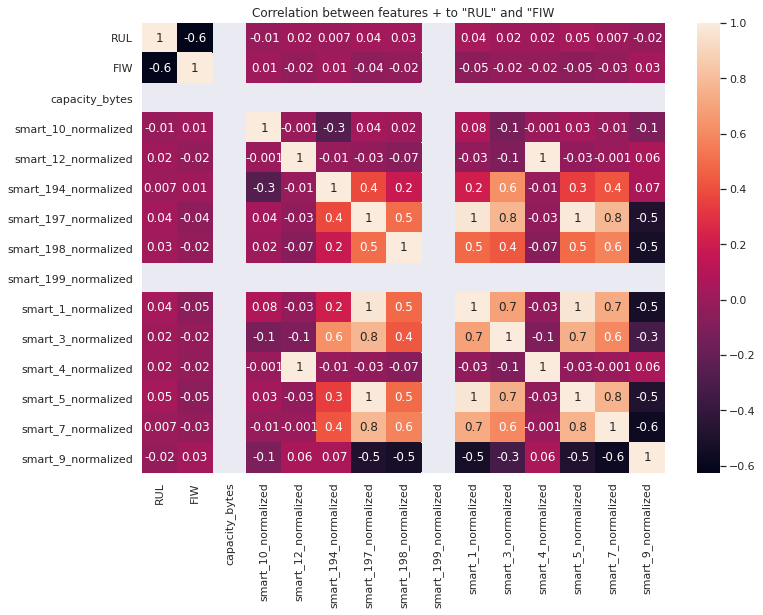

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.heatmap(hDData_failures_data1.drop(['failure','failuremax'], axis='columns').corr(), annot=True, fmt=".1g").set_title('Correlation between features + to "RUL" and "FIW')

In [ ]:
hDData_failures_data1.shape

(5174, 24)

In [ ]:
hDData_failures_data2 = hDData_failures_data1.drop(['capacity_bytes', 'datemax', 'datemin', 'duration', 'failDate', 'failure', 'failuremax','serial_number'], axis=1)
hDData_failures_data2.reset_index(drop=True, inplace=True)
hDData_failures_data2.set_index('date', inplace=True)
hDData_failures_data2.head()

,RUL,FIW,model,smart_10_normalized,smart_12_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized
date,,,,,,,,,,,,,,,
2016-01-01,110,0,TOSHIBA DT01ACA300,95,100,253.0,100,100,200,99,132,100,100,100,98
2016-01-02,109,0,TOSHIBA DT01ACA300,95,100,253.0,100,100,200,98,132,100,100,100,98
2016-01-03,108,0,TOSHIBA DT01ACA300,95,100,253.0,100,100,200,97,132,100,100,100,98
2016-01-04,107,0,TOSHIBA DT01ACA300,95,100,253.0,100,100,200,99,132,100,100,100,98
2016-01-05,106,0,TOSHIBA DT01ACA300,95,100,253.0,100,100,200,99,132,100,100,100,98


In [ ]:
hDData_failures_data3 = pd.get_dummies(hDData_failures_data2, columns=["model"])
print(hDData_failures_data3.columns)
hDData_failures_data3.head()

Index(['RUL', 'FIW', 'smart_10_normalized', 'smart_12_normalized',
       'smart_194_normalized', 'smart_197_normalized', 'smart_198_normalized',
       'smart_199_normalized', 'smart_1_normalized', 'smart_3_normalized',
       'smart_4_normalized', 'smart_5_normalized', 'smart_7_normalized',
       'smart_9_normalized', 'model_HGST HMS5C4040ALE640',
       'model_HGST HMS5C4040BLE640', 'model_Hitachi HDS5C3030ALA630',
       'model_Hitachi HDS5C4040ALE630', 'model_Hitachi HDS722020ALA330',
       'model_ST3160316AS', 'model_ST3160318AS', 'model_ST320LT007',
       'model_ST4000DM000', 'model_ST4000DX000', 'model_ST6000DX000',
       'model_ST9250315AS', 'model_TOSHIBA DT01ACA300',
       'model_TOSHIBA MD04ABA500V', 'model_WDC WD10EADS',
       'model_WDC WD1600AAJB', 'model_WDC WD1600AAJS', 'model_WDC WD20EFRX',
       'model_WDC WD30EFRX', 'model_WDC WD3200BEKT', 'model_WDC WD3200BEKX',
       'model_WDC WD60EFRX', 'model_WDC WD800AAJB', 'model_WDC WD800AAJS',
       'model_WDC WD80

,RUL,FIW,smart_10_normalized,smart_12_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,model_HGST HMS5C4040ALE640,model_HGST HMS5C4040BLE640,model_Hitachi HDS5C3030ALA630,model_Hitachi HDS5C4040ALE630,model_Hitachi HDS722020ALA330,model_ST3160316AS,model_ST3160318AS,model_ST320LT007,model_ST4000DM000,model_ST4000DX000,model_ST6000DX000,model_ST9250315AS,model_TOSHIBA DT01ACA300,model_TOSHIBA MD04ABA500V,model_WDC WD10EADS,model_WDC WD1600AAJB,model_WDC WD1600AAJS,model_WDC WD20EFRX,model_WDC WD30EFRX,model_WDC WD3200BEKT,model_WDC WD3200BEKX,model_WDC WD60EFRX,model_WDC WD800AAJB,model_WDC WD800AAJS,model_WDC WD800BB
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,110,0,95,100,253.0,100,100,200,99,132,100,100,100,98,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-02,109,0,95,100,253.0,100,100,200,98,132,100,100,100,98,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-03,108,0,95,100,253.0,100,100,200,97,132,100,100,100,98,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-04,107,0,95,100,253.0,100,100,200,99,132,100,100,100,98,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-05,106,0,95,100,253.0,100,100,200,99,132,100,100,100,98,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#current stage failure records balance
hDDataModelValCounts1 = hDData_failures_data1.model.value_counts()
hDDataModelValCounts1 = pd.DataFrame(hDDataModelValCounts1).reset_index()
hDDataModelValCounts1.columns = ['model', 'modelCount']
hDDataFailByModelCounts1 = hDData_failures_data1[hDData_failures_data1['failure'] == 1].groupby('model')['failure'].count()
hDDataFailByModelProp1 = pd.merge(hDDataModelValCounts1.reset_index(), hDDataFailByModelCounts1.reset_index(), on = 'model')
hDDataFailByModelProp1['failPercent'] = (hDDataFailByModelProp1['failure']/hDDataFailByModelProp1['modelCount'])*100
hDDataFailByModelProp1.sort_values('failPercent', ascending = False,inplace=True)
hDDataFailByModelProp1

,index,model,modelCount,failure,failPercent
24,24,WDC WD20EFRX,4,2,50.000000
21,21,WDC WD10EADS,5,2,40.000000
23,23,WDC WD800AAJB,5,1,20.000000
22,22,WDC WD60EFRX,5,1,20.000000
20,20,HGST HMS5C4040BLE640,5,1,20.000000
19,19,HGST HMS5C4040ALE640,14,2,14.285714
12,12,Hitachi HDS5C4040ALE630,45,3,6.666667
18,18,ST9250315AS,19,1,5.263158
2,2,Hitachi HDS722020ALA330,286,13,4.545455
5,5,Hitachi HDS5C3030ALA630,120,5,4.166667


## Remaining useful life (RUL)
Trying to predict how many days before the HDD fails. 

In [ ]:
y = hDData_failures_data3.RUL
X = hDData_failures_data3.drop(['RUL', 'FIW'], axis='columns')
print(X.shape, y.shape)

(5174, 37) (5174,)


In [ ]:
hDData_failures_data3.RUL.describe()

count    5174.000000
mean       49.557596
std        44.299777
min         0.000000
25%         7.000000
50%        21.500000
75%        95.000000
max       119.000000
Name: RUL, dtype: float64

In [ ]:
model = GradientBoostingRegressor()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('neg_mean_squared_error: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

neg_mean_squared_error: -1223.388 (50.940)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
gbmtree = GradientBoostingRegressor()
gbmModel = gbmtree.fit(X_train,y_train)
gbmPred = gbmModel.predict(X_test)
mse_RUL = mean_squared_error(gbmPred, y_test)
print('mse_RUL: ',round(mse_RUL,2))

mse_RUL:  1188.19


Text(0.5, 1.0, 'Feature Importance, RUL')

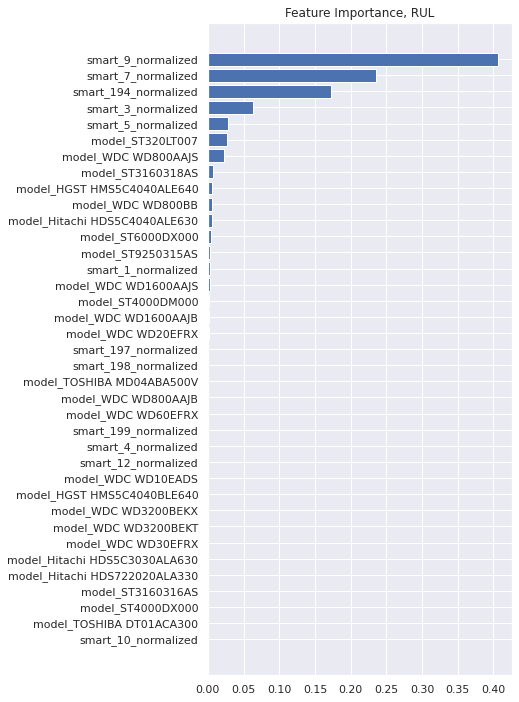

In [ ]:
feature_importance = gbmtree.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance, RUL')

## Failure within time window

In [ ]:
y = hDData_failures_data3.FIW
X = hDData_failures_data3.drop(['RUL', 'FIW'], axis='columns')
print(X.shape, y.shape)

(5174, 37) (5174,)


In [ ]:
#f1_macro
model = GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
print('f1: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

f1: 0.221 (0.034)


Text(0.5, 1.0, 'Feature Importance, failure within time window')

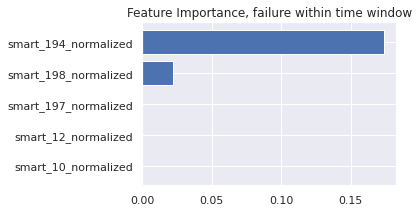

In [ ]:
# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(X, y)
feature_importance = model.feature_importances_[:5]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance, failure within time window')

In [ ]:
X.describe()

,smart_10_normalized,smart_12_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,model_HGST HMS5C4040ALE640,model_HGST HMS5C4040BLE640,model_Hitachi HDS5C3030ALA630,model_Hitachi HDS5C4040ALE630,model_Hitachi HDS722020ALA330,model_ST3160316AS,model_ST3160318AS,model_ST320LT007,model_ST4000DM000,model_ST4000DX000,model_ST6000DX000,model_ST9250315AS,model_TOSHIBA DT01ACA300,model_TOSHIBA MD04ABA500V,model_WDC WD10EADS,model_WDC WD1600AAJB,model_WDC WD1600AAJS,model_WDC WD20EFRX,model_WDC WD30EFRX,model_WDC WD3200BEKT,model_WDC WD3200BEKX,model_WDC WD60EFRX,model_WDC WD800AAJB,model_WDC WD800AAJS,model_WDC WD800BB
count,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.0,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000
mean,99.960379,99.999807,57.994202,114.350986,104.087940,200.0,125.361229,103.689795,99.999807,113.539235,96.666602,80.719559,0.002706,0.000966,0.023193,0.008697,0.055276,0.004832,0.013336,0.095284,0.611133,0.014109,0.010050,0.003672,0.007924,0.005025,0.000966,0.012756,0.011790,0.000773,0.038268,0.005798,0.008118,0.000966,0.000966,0.054117,0.009277
std,0.443367,0.013902,60.646016,35.132388,19.830516,0.0,31.416940,19.938176,0.013902,35.953660,31.320552,14.785012,0.051952,0.031074,0.150530,0.092862,0.228541,0.069350,0.114720,0.293635,0.487540,0.117952,0.099756,0.060493,0.088673,0.070717,0.031074,0.112231,0.107949,0.027797,0.191862,0.075932,0.089739,0.031074,0.031074,0.226270,0.095879
min,95.000000,99.000000,16.000000,1.000000,81.000000,200.0,46.000000,88.000000,99.000000,1.000000,66.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,100.000000,24.000000,100.000000,100.000000,200.0,112.000000,92.000000,100.000000,100.000000,84.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,100.000000,29.000000,100.000000,100.000000,200.0,117.000000,97.000000,100.000000,100.000000,87.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100.000000,100.000000,40.000000,100.000000,100.000000,200.0,119.000000,100.000000,100.000000,100.000000,95.000000,93.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,253.000000,200.000000,200.000000,200.0,200.000000,253.000000,100.000000,200.000000,200.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X.apply(pd.Series.nunique)

smart_10_normalized               2
smart_12_normalized               2
smart_194_normalized             77
smart_197_normalized              6
smart_198_normalized              5
smart_199_normalized              1
smart_1_normalized               57
smart_3_normalized               46
smart_4_normalized                2
smart_5_normalized               39
smart_7_normalized               30
smart_9_normalized               59
model_HGST HMS5C4040ALE640        2
model_HGST HMS5C4040BLE640        2
model_Hitachi HDS5C3030ALA630     2
model_Hitachi HDS5C4040ALE630     2
model_Hitachi HDS722020ALA330     2
model_ST3160316AS                 2
model_ST3160318AS                 2
model_ST320LT007                  2
model_ST4000DM000                 2
model_ST4000DX000                 2
model_ST6000DX000                 2
model_ST9250315AS                 2
model_TOSHIBA DT01ACA300          2
model_TOSHIBA MD04ABA500V         2
model_WDC WD10EADS                2
model_WDC WD1600AAJB        

#Imbalanced dataset  

SMOTE doesn't work because there are many models for which the number of failures is less than the number of neighbors needed (default = 6).  

Error message: ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 6

The default can be changed but it is meaningless to try to SMOTE with many models having single failures.   

Command: over=SMOTE(kind='regular',k_neighbors=2)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

In [ ]:
hDData_failures_data1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5174 entries, ('13H883WAS', 4045) to ('Z4D04BH9', 177)
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   RUL                   5174 non-null   int64          
 1   FIW                   5174 non-null   int64          
 2   capacity_bytes        5174 non-null   float64        
 3   date                  5174 non-null   datetime64[ns] 
 4   datemax               5174 non-null   object         
 5   datemin               5174 non-null   datetime64[ns] 
 6   duration              5174 non-null   timedelta64[ns]
 7   failDate              5174 non-null   datetime64[ns] 
 8   failure               5174 non-null   int64          
 9   failuremax            5174 non-null   int64          
 10  model                 5174 non-null   object         
 11  serial_number         5174 non-null   object         
 12  smart_10_normalized   5174 non-

In [ ]:
hDDataModelValCounts1 = hDData_failures_data1.model.value_counts()
hDDataModelValCounts1 = pd.DataFrame(hDDataModelValCounts1).reset_index()
hDDataModelValCounts1.columns = ['model', '# of observations']
hDDataFailByModelCounts1 = hDData_failures_data1[hDData_failures_data1['failure'] == 1].groupby('model')['failure'].count()
hDDataFailByModelProp1 = pd.merge(hDDataModelValCounts1.reset_index(), hDDataFailByModelCounts1.reset_index(), on = 'model')
hDDataFailByModelProp1['failPercent'] = (hDDataFailByModelProp1['failure']/hDDataFailByModelProp1['# of observations'])*100
hDDataFailByModelProp1.sort_values('failPercent', ascending = False,inplace=True)
print(hDDataFailByModelProp1['model'][hDDataFailByModelProp1['failPercent']>10])
print(hDDataFailByModelProp1['model'][(hDDataFailByModelProp1['failPercent']<10) & (hDDataFailByModelProp1['failure']>1)])
hDDataFailByModelProp1.drop('index', axis='columns')

24            WDC WD20EFRX
21            WDC WD10EADS
23           WDC WD800AAJB
22            WDC WD60EFRX
20    HGST HMS5C4040BLE640
19    HGST HMS5C4040ALE640
Name: model, dtype: object
12    Hitachi HDS5C4040ALE630
2     Hitachi HDS722020ALA330
5     Hitachi HDS5C3030ALA630
0                 ST4000DM000
10                ST6000DX000
9              WDC WD1600AAJS
1                  ST320LT007
8              WDC WD1600AAJB
4                WDC WD30EFRX
7                 ST3160318AS
6                 ST4000DX000
3               WDC WD800AAJS
Name: model, dtype: object


,model,# of observations,failure,failPercent
24,WDC WD20EFRX,4,2,50.000000
21,WDC WD10EADS,5,2,40.000000
23,WDC WD800AAJB,5,1,20.000000
22,WDC WD60EFRX,5,1,20.000000
20,HGST HMS5C4040BLE640,5,1,20.000000
19,HGST HMS5C4040ALE640,14,2,14.285714
12,Hitachi HDS5C4040ALE630,45,3,6.666667
18,ST9250315AS,19,1,5.263158
2,Hitachi HDS722020ALA330,286,13,4.545455
5,Hitachi HDS5C3030ALA630,120,5,4.166667


In [ ]:
hDDataModelValCounts1_x = df1.model.value_counts()
hDDataModelValCounts1_x = pd.DataFrame(hDDataModelValCounts1_x).reset_index()
hDDataModelValCounts1_x.columns = ['model', '# of observations']
hDDataFailByModelCounts1_x = df1[df1['failure'] == 1].groupby('model')['failure'].count()
hDDataFailByModelProp1_x = pd.merge(hDDataModelValCounts1_x.reset_index(), hDDataFailByModelCounts1_x.reset_index(), on = 'model')
hDDataFailByModelProp1_x['failPercent'] = (hDDataFailByModelProp1_x['failure']/hDDataFailByModelProp1_x['# of observations'])*100
hDDataFailByModelProp1_x.sort_values('failPercent', ascending = False,inplace=True)
# print(hDDataFailByModelProp1['model'][hDDataFailByModelProp1['failPercent']>10])
# print(hDDataFailByModelProp1['model'][(hDDataFailByModelProp1['failPercent']<10) & (hDDataFailByModelProp1['failure']>1)])
hDDataFailByModelProp1_x.drop('index', axis='columns')

,model,# of observations,failure,failPercent
24,WDC WD3200BEKT,2,1,50.000000
19,WDC WD800AAJS,28,6,21.428571
21,WDC WD1600AAJB,10,2,20.000000
23,WDC WD800BB,6,1,16.666667
14,ST320LT007,115,15,13.043478
22,WDC WD800AAJB,10,1,10.000000
20,WDC WD3200BEKX,21,1,4.761905
16,ST3160318AS,95,2,2.105263
18,TOSHIBA MD04ABA500V,91,1,1.098901
17,TOSHIBA DT01ACA300,94,1,1.063830


In [ ]:
hDData_failures_data1
#df_20210213 = hDData_failures_data1[hDData_failures_data1['model'].isin(hDDataFailByModelProp1['model'][hDDataFailByModelProp1['failPercent']<10])]
#df_20210213.shape
#hDData_failures_data1['model'].isin(hDDataFailByModelProp1['model'][hDDataFailByModelProp1['failPercent']<10]).unique()
#modelList = hDData['model'][hDData['failure']==1].value_counts().sort_values(ascending=False)[:25]
#modelList
modelList_lowCount = hDDataFailByModelProp1['model'][hDDataFailByModelProp1['failPercent']<10]
hDData_failures_data1_lowCount = hDData_failures_data1[hDData_failures_data1['model'].isin(modelList_lowCount)]
hDData_failures_data1_OKCount = pd.concat([hDData_failures_data1,hDData_failures_data1_lowCount]).drop_duplicates(keep=False)
print(hDData_failures_data1.shape)
print(hDData_failures_data1_lowCount.shape)
print(hDData_failures_data1_OKCount.shape)

(5174, 24)
(5136, 24)
(38, 24)


In [ ]:
hDData_failures_data1_lowCount1 = pd.DataFrame()
for model in (modelList_lowCount.to_list()):
  #print(model)
  tempDF = hDData_failures_data1[hDData_failures_data1.model == model]
  #print(tempDF.shape)
  #hDData_failures_dataSMOTE = pd.get_dummies(hDData_failures_data1, columns=["model"])
  ySMOTE1 = tempDF.failure
  XSMOTE1 = tempDF.drop(['capacity_bytes', 'date', 'datemax', 'datemin', 'duration','failDate', 'failure', 'failuremax', 'serial_number','model'], axis=1)
  # define pipeline
  over = SMOTE(sampling_strategy=0.1)
  #oversampler=SMOTE(kind='regular',k_neighbors=2)
  under = RandomUnderSampler(sampling_strategy=0.5)
  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)
  # transform the dataset
  #XSMOTE2, ySMOTE2 = pipeline.fit_resample(XSMOTE1, ySMOTE1)

In [ ]:
#modelList = ['Hitachi HDS5C4040ALE630', 'WDC WD800BB','WDC WD800AAJS', 'WDC WD3200BEKT']
modelList = ['Hitachi HDS5C4040ALE630', 'WDC WD800BB','WDC WD800AAJS', 'WDC WD3200BEKT','ST4000DM000', 'WDC WD10EADS']
hDDataFailByModelProp1[hDDataFailByModelProp1.model.isin(modelList)].drop('index', axis='columns')

,model,# of observations,failure,failPercent
21,WDC WD10EADS,5,2,40.000000
12,Hitachi HDS5C4040ALE630,45,3,6.666667
0,ST4000DM000,3162,131,4.142948
15,WDC WD3200BEKT,30,1,3.333333
3,WDC WD800AAJS,280,6,2.142857
11,WDC WD800BB,48,1,2.083333


In [ ]:
hDDataFailByModelProp1_x[hDDataFailByModelProp1_x.model.isin(modelList)].drop('index', axis='columns')

,model,# of observations,failure,failPercent
24,WDC WD3200BEKT,2,1,50.000000
19,WDC WD800AAJS,28,6,21.428571
23,WDC WD800BB,6,1,16.666667
11,WDC WD10EADS,256,2,0.781250
0,ST4000DM000,63946,131,0.204860
5,Hitachi HDS5C4040ALE630,5271,3,0.056915


(5174, 37) (5174,)


Text(0.5, 1.0, 'Correlation between features + to "RUL" and "FIW')

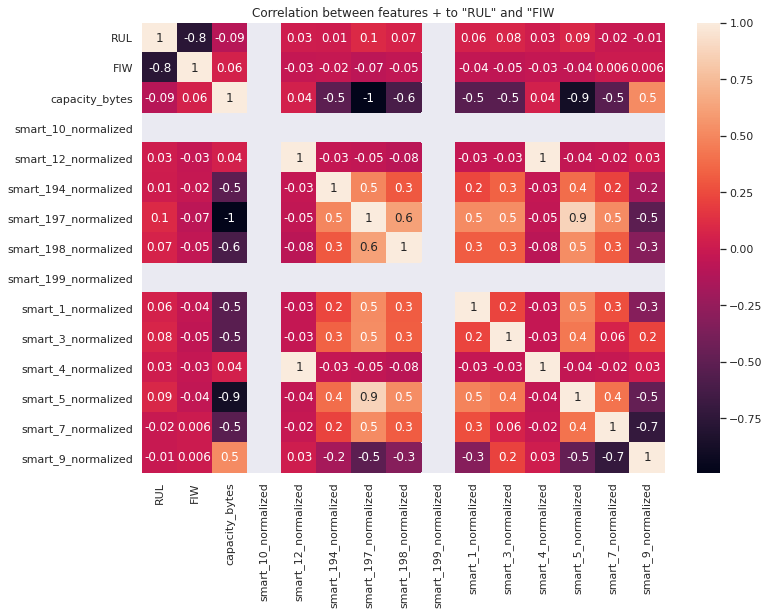

In [ ]:
#modelList = ['Hitachi HDS5C4040ALE630', 'WDC WD800BB','WDC WD800AAJS', 'WDC WD3200BEKT']

y = hDData_failures_data3.RUL
X = hDData_failures_data3.drop(['RUL', 'FIW'], axis='columns')
print(X.shape, y.shape)

df_modelList = hDData_failures_data1[hDData_failures_data1['model'].isin(modelList)]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df_modelList.drop(['failure','failuremax'], axis='columns').corr(method='spearman'), annot=True, fmt=".1g").set_title('Correlation between features + to "RUL" and "FIW')


In [ ]:
df_modelList1 = df_modelList.drop(['capacity_bytes', 'datemax', 'datemin', 'duration', 'failDate', 'failure', 'failuremax','serial_number'], axis=1)
df_modelList1.reset_index(drop=True, inplace=True)
df_modelList1.set_index('date', inplace=True)

df_modelList2 = pd.get_dummies(df_modelList1, columns=["model"])


In [ ]:
df_modelList[['datemax', 'datemin', 'duration']][df_modelList['duration']>pd.Timedelta(50,'d')]

datemax    datemin duration
serial_number                                      
PL1311LAG2B1NH 3228  2016-04-01 2016-01-01  91 days
               3229  2016-04-01 2016-01-01  91 days
               3230  2016-04-01 2016-01-01  91 days
               3231  2016-04-01 2016-01-01  91 days
               3232  2016-04-01 2016-01-01  91 days
...                         ...        ...      ...
Z305AT4W       2568  2016-04-16 2016-01-01 106 days
               2569  2016-04-16 2016-01-01 106 days
               2570  2016-04-16 2016-01-01 106 days
               2571  2016-04-16 2016-01-01 106 days
               2572  2016-04-16 2016-01-01 106 days

[2906 rows x 3 columns]

In [ ]:
hDData_failures_data3.RUL.describe()

count    5174.000000
mean       49.557596
std        44.299777
min         0.000000
25%         7.000000
50%        21.500000
75%        95.000000
max       119.000000
Name: RUL, dtype: float64

In [ ]:
y = df_modelList2.RUL
X = df_modelList2.drop(['RUL', 'FIW'], axis='columns')
print(X.shape, y.shape)

model = GradientBoostingRegressor()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('neg_mean_squared_error: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


(3570, 18) (3570,)
neg_mean_squared_error: -1025.642 (43.681)


In [ ]:
y.describe()

count    3570.000000
mean       49.252381
std        44.264550
min         0.000000
25%         7.000000
50%        21.000000
75%        95.000000
max       119.000000
Name: RUL, dtype: float64

In [ ]:
y = df_modelList2.FIW
X = df_modelList2.drop(['RUL', 'FIW'], axis='columns')
print(X.shape, y.shape)

model = GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
print('f1: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


(3570, 18) (3570,)
f1: 0.242 (0.047)


Text(0.5, 1.0, 'Feature Importance, failure within time window')

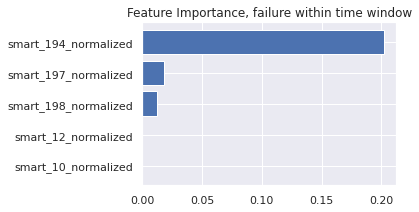

In [ ]:
model = GradientBoostingClassifier()
model.fit(X, y)
feature_importance = model.feature_importances_[:5]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance, failure within time window')


## Extracting insights from failure observations


In [ ]:
medianAge = []
meanAge = []
numObs = []
numFails = []
#modelList = ['Hitachi HDS5C4040ALE630', 'WDC WD800BB','WDC WD800AAJS', 'WDC WD3200BEKT']
for i, model in enumerate(modelList):    
    medianAge.append(df1['duration'][(df1['model']==model) & (df1['failure']==1)].median())
    #print(modelList, medianAge)
    meanAge.append(df1['duration'][(df1['model']==model) & (df1['failure']==1)].mean())
    numObs.append(len(df1['duration'][(df1['model']==model)]))
    numFails.append(len(df1['duration'][(df1['model']==model) & (df1['failure']==1)]))
modelPerformance = pd.DataFrame(modelList)
modelPerformance['# observations'] = numObs
modelPerformance['# failures'] = numFails
modelPerformance['MedianAge'] = medianAge
modelPerformance['MeanAge'] = meanAge
modelPerformance.columns = ['model', '# of observations', '# of failures', 'MedianAge, Days','MeanAge, Days']
#print(modelPerformance)
tidy = modelPerformance.melt(id_vars='model').rename(columns=str.title)
modelPerformance

,model,# of observations,# of failures,"MedianAge, Days","MeanAge, Days"
0,Hitachi HDS5C4040ALE630,5271,3,1.0,7.000000
1,WDC WD800BB,6,1,26.0,26.000000
2,WDC WD800AAJS,28,6,25.0,24.666667
3,WDC WD3200BEKT,2,1,8.0,8.000000
4,ST4000DM000,63946,131,11.0,11.916031
5,WDC WD10EADS,256,2,0.5,0.500000


In [ ]:
tidy

,Model,Variable,Value
0,Hitachi HDS5C4040ALE630,# of observations,5271.000000
1,WDC WD800BB,# of observations,6.000000
2,WDC WD800AAJS,# of observations,28.000000
3,WDC WD3200BEKT,# of observations,2.000000
4,ST4000DM000,# of observations,63946.000000
5,WDC WD10EADS,# of observations,256.000000
6,Hitachi HDS5C4040ALE630,# of failures,3.000000
7,WDC WD800BB,# of failures,1.000000
8,WDC WD800AAJS,# of failures,6.000000
9,WDC WD3200BEKT,# of failures,1.000000


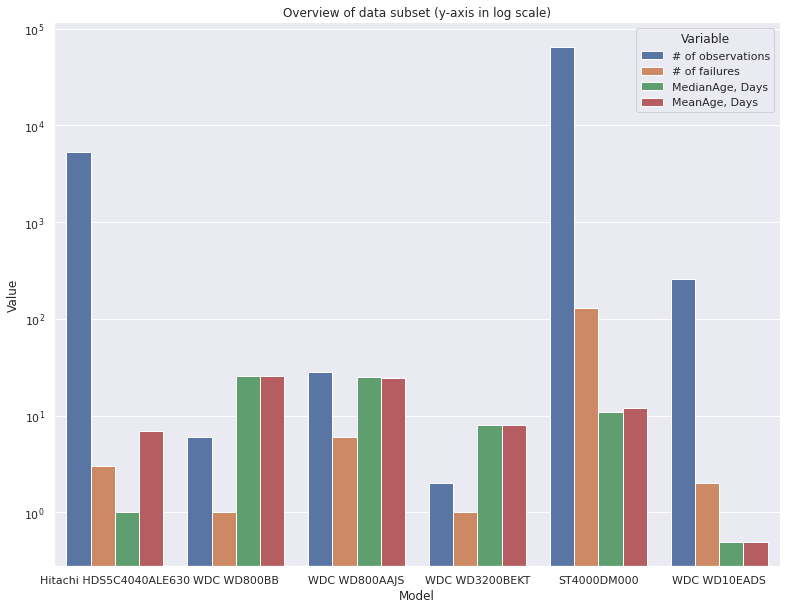

In [ ]:
fig, ax1 = plt.subplots(figsize=(13, 10))
sns.barplot(x='Model', y='Value', hue='Variable', data=tidy, ax=ax1).set_yscale("log")
ax1.set_title('Overview of data subset (y-axis in log scale)')
sns.despine(fig)

#Survival analysis

In [ ]:
# #subset models for discusion
# modelList = ['Hitachi HDS5C4040ALE630', 'WDC WD800BB','WDC WD800AAJS', 'WDC WD3200BEKT']
# colorList = ['tab:orange', 'tab:green', 'tab:red', 'tab:blue']
# serialList = ['PL1321LAGAREUH', 'WD-WCAMD1671734', 'WD-WMAV3J875025', 'WD-WX71A9290300']
# res['start'] = pd.to_datetime(res['start'])
# res['end'] = pd.to_datetime(res['end'])
# figure(figsize=(10, 3))
# for i, serial in enumerate(serialList): 
#     ax = plt.subplot(111)
#     ax.broken_barh(list(zip(res['start'][res.serial_number == serial].values, (res['end'][res.serial_number == serial] - res['start'][res.serial_number == serial].values).values)), (i, 0.2), facecolors = colorList[i], label='%s' %modelList[i])
# plt.xticks(rotation=45)
# plt.yticks([])
# plt.legend(loc='center')
# plt.title('Patchy event recordings, for a single device, by model')

Text(0.5, 1.0, 'Patchy event recordings, for a single device, by model')

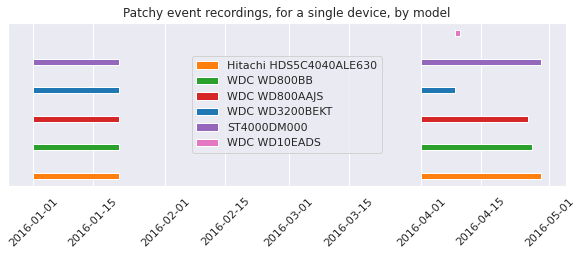

In [ ]:
modelList = ['Hitachi HDS5C4040ALE630', 'WDC WD800BB','WDC WD800AAJS', 'WDC WD3200BEKT','ST4000DM000', 'WDC WD10EADS']

colorList = ['tab:orange', 'tab:green', 'tab:red', 'tab:blue', 'tab:purple', 'tab:pink']
serialList = ['PL1321LAGAREUH', 'WD-WCAMD1671734', 'WD-WMAV3J875025', 'WD-WX71A9290300', 'S3000FZ5', 'WD-WCAU44503142']
res['start'] = pd.to_datetime(res['start'])
res['end'] = pd.to_datetime(res['end'])
figure(figsize=(10, 3))
for i, serial in enumerate(serialList): 
    ax = plt.subplot(111)
    ax.broken_barh(list(zip(res['start'][res.serial_number == serial].values, (res['end'][res.serial_number == serial] - res['start'][res.serial_number == serial].values).values)), (i, 0.2), facecolors = colorList[i], label='%s' %modelList[i])
plt.xticks(rotation=45)
plt.yticks([])
plt.legend(loc='center')
plt.title('Patchy event recordings, for a single device, by model')

In [ ]:
modelList = ['Hitachi HDS5C4040ALE630', 'WDC WD800BB','WDC WD800AAJS', 'WDC WD3200BEKT','ST4000DM000', 'WDC WD10EADS']

#modelList

tempFile = df1[df1['model'].isin(modelList)]
tempFile.groupby('model').first()

,Unnamed: 0,serial_number,start,end,failure,duration
model,,,,,,
Hitachi HDS5C4040ALE630,18136,PL1301LAG2VA9A,2016-01-01,2016-01-21,0,20
ST4000DM000,45693,S3000FZ5,2016-01-01,2016-01-21,0,20
WDC WD10EADS,63211,WD-WCAU44503142,2016-04-09,2016-04-10,0,1
WDC WD3200BEKT,66816,WD-WX71A9290300,2016-01-01,2016-01-21,0,20
WDC WD800AAJS,63458,WD-WCAV3E973409,2016-01-01,2016-01-21,0,20
WDC WD800BB,63204,WD-WCAMD1587919,2016-01-01,2016-01-21,0,20


In [ ]:
#modelList = ['Hitachi HDS5C4040ALE630', 'WDC WD800BB','WDC WD800AAJS', 'WDC WD3200BEKT']
df1_ModelSubset = df1[df1['model'].isin(modelList)]
df1_ModelSubset.head()

,Unnamed: 0,serial_number,start,end,model,failure,duration
18136,18136,PL1301LAG2VA9A,2016-01-01,2016-01-21,Hitachi HDS5C4040ALE630,0,20
18137,18137,PL1301LAG2VA9A,2016-04-01,2016-04-29,Hitachi HDS5C4040ALE630,0,28
18138,18138,PL1301LAG2VL0A,2016-01-01,2016-01-21,Hitachi HDS5C4040ALE630,0,20
18139,18139,PL1301LAG2VL0A,2016-04-01,2016-04-29,Hitachi HDS5C4040ALE630,0,28
18140,18140,PL1301LAG2VL6A,2016-01-01,2016-01-21,Hitachi HDS5C4040ALE630,0,20


In [ ]:
df1.shape

(117960, 7)

In [ ]:
results = pairwise_logrank_test(df1_ModelSubset['duration'], df1_ModelSubset['model'], df1_ModelSubset['failure'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                        test_statistic      p  -log2(p)
Hitachi HDS5C4040ALE630 ST4000DM000               5.41   0.02      5.64
                        WDC WD10EADS             18.72 <0.005     16.01
                        WDC WD3200BEKT          751.37 <0.005    547.10
                        WDC WD800AAJS           799.60 <0.005    581.94
                        WDC WD800BB             262.02 <0.005    193.36
ST4000DM000             WDC WD10EADS             24.96 <0.005     20.70
                        WDC WD3200BEKT          389.80 <0.005    285.82
                        WDC WD800AAJS           621.79 <0.005    453.49
                        WDC WD800BB              90.00 <0.005     68.51
WDC WD10EADS            WDC WD3200BEKT           13.30 <0.005     11.88
                        WDC WD800AAJS             0.22   0.64      0.65
                        WDC WD800BB               0.05   0.83      0.27
WDC WD3200BEKT          WDC WD800AAJS            14.00 <0.005     12.42
                        WDC WD800BB               3.00   0.08      3.59
WDC WD800AAJS           WDC WD800BB               0.47   0.49      1.02

In [ ]:
#WD3200BEKT
df1[df1['model'].isin(['WDC WD3200BEKT'])]

,Unnamed: 0,serial_number,start,end,model,failure,duration
66816,66816,WD-WX71A9290300,2016-01-01,2016-01-21,WDC WD3200BEKT,0,20
66817,66817,WD-WX71A9290300,2016-04-01,2016-04-09,WDC WD3200BEKT,1,8


In [ ]:
for i, model in enumerate(modelList):
    table = survival_table_from_events(df1['duration'][df1['model']==model], df1['failure'][df1['model']==model])
    print(f'These are the failures for model {model}:','\n',table,'\n')

These are the failures for model Hitachi HDS5C4040ALE630: 
           removed  observed  censored  entrance  at_risk
event_at                                                
0               1         1         0      5271     5271
1               1         1         0         0     5270
20           2638         1      2637         0     5269
26              1         0         1         0     2631
28           2630         0      2630         0     2630 

These are the failures for model WDC WD800BB: 
           removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0         6        6
20.0            5         0         5         0        6
26.0            1         1         0         0        1 

These are the failures for model WDC WD800AAJS: 
           removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0   

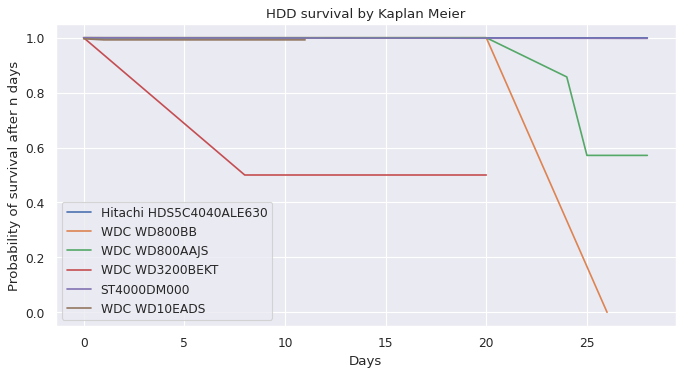

In [ ]:
kmf = KaplanMeierFitter()
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
for i, model in enumerate(modelList):    
    ax = plt.subplot(111)
    kmf.fit(df1['duration'][df1['model']==model], df1['failure'][df1['model']==model], label=model)
    kmf.survival_function_.plot(ax=ax)
    
plt.title('HDD survival by Kaplan Meier')
plt.ylabel('Probability of survival after n days')
plt.xlabel('Days')
plt.legend()
plt.show()  

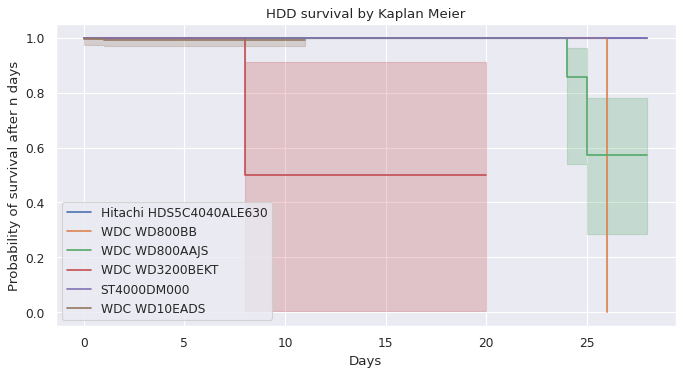

In [ ]:
kmf = KaplanMeierFitter()
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
for i, model in enumerate(modelList):    
    ax = plt.subplot(111)
    kmf.fit(df1['duration'][df1['model']==model], df1['failure'][df1['model']==model], label=model)
    kmf.plot(ax=ax)
    
plt.title('HDD survival by Kaplan Meier')
plt.ylabel('Probability of survival after n days')
plt.xlabel('Days')
plt.legend()
plt.show()  

In [ ]:
kmf = KaplanMeierFitter()
lowerci = []
upperci = []
medianSurvTime = []
t = np.linspace(0, 20, 21)
for i, model in enumerate(modelList):    
    kmf.fit(df1['duration'][df1['model']==model], df1['failure'][df1['model']==model], timeline=t,label=model)
    #print(kmf..)
    #print(kmf.survival_function_)
    #print(kmf.confidence_interval_)
    #print(median_survival_times(kmf.confidence_interval_))
    lowerci.append(median_survival_times(kmf.confidence_interval_).iloc[0,0])
    medianSurvTime.append(kmf.median_survival_time_)
    upperci.append(median_survival_times(kmf.confidence_interval_).iloc[0,1])
survivalPredictions = pd.DataFrame(modelList)
survivalPredictions['Lower CI'] = lowerci
survivalPredictions['Median Survivial Time, Days'] = medianSurvTime
survivalPredictions['Upper CI'] = upperci
survivalPredictions

,0,Lower CI,"Median Survivial Time, Days",Upper CI
0,Hitachi HDS5C4040ALE630,inf,inf,inf
1,WDC WD800BB,inf,inf,inf
2,WDC WD800AAJS,inf,inf,inf
3,WDC WD3200BEKT,8.0,8.0,inf
4,ST4000DM000,inf,inf,inf
5,WDC WD10EADS,inf,inf,inf


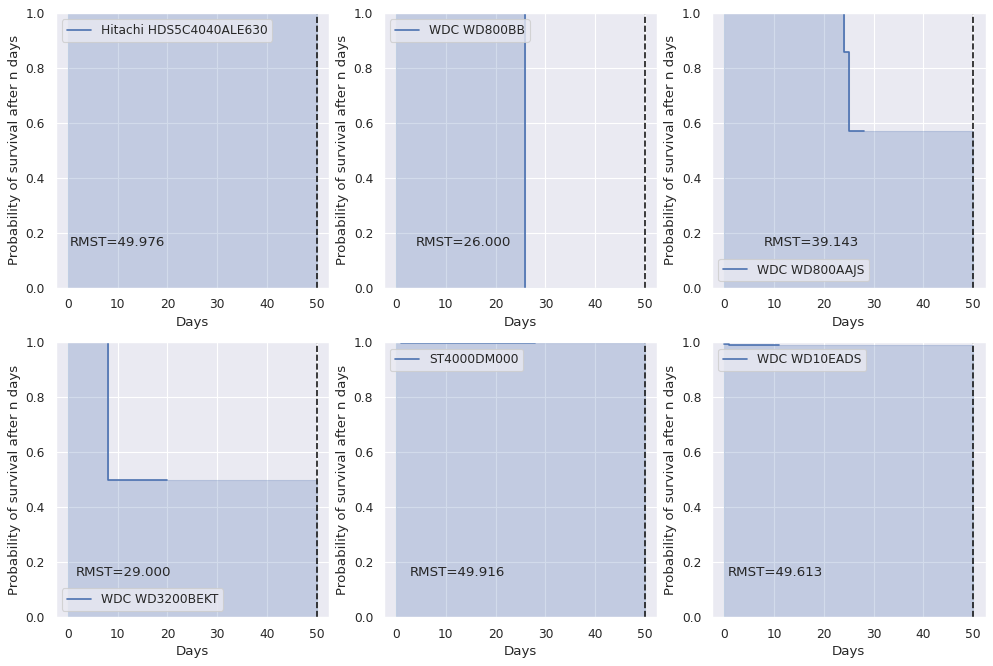

In [ ]:
#this shows survival at a particular point in time, allowing comparisons
time_limit = 50
kmf = KaplanMeierFitter()
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for i, model in enumerate(modelList):    
    ax = plt.subplot(2,3,i+1)
    kmf.fit(df1['duration'][df1['model']==model], df1['failure'][df1['model']==model], label=model)
    #kmf.plot(ax=ax)
    #kmf.plot_cumulative_density()
    rmst_plot(kmf, t=time_limit, ax=ax)
    plt.xlabel('Days')
    plt.ylabel('Probability of survival after n days')

In [ ]:
df2 = pd.merge(res,df[['model','serial_number','failure','date','smart_5_normalized', 'smart_197_normalized','smart_198_normalized']], left_on=['serial_number','end'],right_on=['serial_number','date'], how='left').drop(['date'], axis='columns')
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')] 
df2['duration'] = df2['end']-df2['start']
df2['duration'] = df2.duration.dt.days
print(df2['end'].max())
print(df2['end'].min())

df2 = df2.drop(['serial_number','start','end'], axis='columns')

cols = list(df2)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('failure')))
cols.insert(1, cols.pop(cols.index('duration')))
cols.insert(5, cols.pop(cols.index('model')))

cols
df2 = df2.loc[:, cols]

df2.head()

2016-04-29 00:00:00
2016-01-01 00:00:00


,failure,duration,smart_5_normalized,smart_197_normalized,smart_198_normalized,model
0,0,20,100,100,100,TOSHIBA DT01ACA300
1,0,28,100,100,100,TOSHIBA DT01ACA300
2,0,20,100,100,100,TOSHIBA DT01ACA300
3,0,28,100,100,100,TOSHIBA DT01ACA300
4,0,20,100,100,100,TOSHIBA DT01ACA300


In [ ]:
df2.describe()

,failure,duration,smart_5_normalized,smart_197_normalized,smart_198_normalized
count,117960.000000,117960.000000,117960.000000,117960.000000,117960.000000
mean,0.001738,23.887318,103.239378,103.256536,100.376780
std,0.041652,4.504314,17.772763,17.756022,6.131067
min,0.000000,0.000000,1.000000,1.000000,81.000000
25%,0.000000,20.000000,100.000000,100.000000,100.000000
50%,0.000000,28.000000,100.000000,100.000000,100.000000
75%,0.000000,28.000000,100.000000,100.000000,100.000000
max,1.000000,28.000000,200.000000,200.000000,200.000000


In [ ]:
cph = CoxPHFitter()
cph.fit(df2[['duration', 'failure','smart_5_normalized']],'duration','failure')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 117960 total observations, 117755 right-censored observations>
             duration col = 'duration'
                event col = 'failure'
      baseline estimation = breslow
   number of observations = 117960
number of events observed = 205
   partial log-likelihood = -2355.48
         time fit was run = 2021-02-14 03:23:47 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
smart_5_normalized   0.01       1.01       0.00             0.01             0.02                 1.01                 1.02

                      z      p   -log2(p)
covariate                                
smart_5_normalized 5.48 <0.005      24.51
---
Concordance = 0.50
Partial AIC = 4712.97
log-likelihood ratio test = 21.71 on 1 df
-log2(p) of ll-ratio test = 18.27

In [ ]:
df2.columns

Index(['failure', 'duration', 'smart_5_normalized', 'smart_197_normalized',
       'smart_198_normalized', 'model'],
      dtype='object')

In [ ]:
cph = CoxPHFitter()
cph.fit(df2[['duration', 'failure','smart_5_normalized', 'smart_197_normalized', 'smart_198_normalized']],'duration','failure', show_progress=True, step_size = 0.5)
cph.print_summary()

Iteration 1: norm_delta = 72.65588, step_size = 0.5000, log_lik = -2366.34051, newton_decrement = 492.68367, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.21532, step_size = 0.0500, log_lik = -2706.99810, newton_decrement = 636.47178, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.06501, step_size = 0.0650, log_lik = -2628.35684, newton_decrement = 357.19841, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.90396, step_size = 0.1099, log_lik = -2554.47255, newton_decrement = 233.28132, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.67296, step_size = 0.1856, log_lik = -2476.33964, newton_decrement = 130.14454, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.46933, step_size = 0.3137, log_lik = -2407.74146, newton_decrement = 59.71300, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.33750, step_size = 0.5302, log_lik = -2360.11307, newton_decrement = 22.25807, seconds_since_start = 0.1
Iteration 8: norm_delta = 0.26931, step_size = 0.6500, log_lik 

<lifelines.CoxPHFitter: fitted with 117960 total observations, 117755 right-censored observations>
             duration col = 'duration'
                event col = 'failure'
      baseline estimation = breslow
   number of observations = 117960
number of events observed = 205
   partial log-likelihood = -2326.67
         time fit was run = 2021-02-14 03:23:48 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
smart_5_normalized    -0.08       0.93       0.01            -0.09            -0.06                 0.91                 0.94
smart_197_normalized   0.09       1.09       0.01             0.08             0.10                 1.08                 1.11
smart_198_normalized   0.02       1.02       0.00             0.01             0.03                 1.01                 1.03

                          z      p   -log2(p)
covariate                                    
smart_5_normalized   -12.29 <0.005     112.95
smart_197_normalized  12.95 <0.005     125.07
smart_198_normalized   3.71 <0.005      12.24
---
Concordance = 0.57
Partial AIC = 4659.34
log-likelihood ratio test = 79.34 on 3 df
-log2(p) of ll-ratio test = 54.39

In [ ]:
cph.check_assumptions(df2[['duration', 'failure','smart_5_normalized', 'smart_197_normalized', 'smart_198_normalized']], p_value_threshold=0.05, show_plots=True)

Proportional hazard assumption looks okay.


[]

In [ ]:
df2.columns

Index(['failure', 'duration', 'smart_5_normalized', 'smart_197_normalized',
       'smart_198_normalized', 'model'],
      dtype='object')

In [ ]:
cph_model1 = CoxPHFitter()
cph_model1.fit(df2[['duration', 'failure','smart_5_normalized','model']],'duration','failure', show_progress=True, step_size = 0.1, strata=['model'])
cph_model1.print_summary()

Iteration 1: norm_delta = 37.08305, step_size = 0.1000, log_lik = -1879.51497, newton_decrement = 438.84250, seconds_since_start = 0.1
Iteration 2: norm_delta = 10.58565, step_size = 0.0100, log_lik = -1870.80709, newton_decrement = 122.80559, seconds_since_start = 0.3
Iteration 3: norm_delta = 9.41519, step_size = 0.0033, log_lik = -1870.01020, newton_decrement = 108.85094, seconds_since_start = 0.4
Iteration 4: norm_delta = 9.01095, step_size = 0.0014, log_lik = -1869.71148, newton_decrement = 104.03129, seconds_since_start = 0.6
Iteration 5: norm_delta = 8.85270, step_size = 0.0006, log_lik = -1869.59081, newton_decrement = 102.14449, seconds_since_start = 0.8
Iteration 6: norm_delta = 8.78788, step_size = 0.0002, log_lik = -1869.54074, newton_decrement = 101.37159, seconds_since_start = 0.9
Iteration 7: norm_delta = 8.76084, step_size = 0.0001, log_lik = -1869.51975, newton_decrement = 101.04920, seconds_since_start = 1.1
Iteration 8: norm_delta = 8.74948, step_size = 0.0000, log_l

<lifelines.CoxPHFitter: fitted with 117960 total observations, 117755 right-censored observations>
             duration col = 'duration'
                event col = 'failure'
                   strata = ['model']
      baseline estimation = breslow
   number of observations = 117960
number of events observed = 205
   partial log-likelihood = -1869.51
         time fit was run = 2021-02-14 03:24:21 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
smart_5_normalized  -0.02       0.98       0.03            -0.09             0.04                 0.91                 1.04

                       z    p   -log2(p)
covariate                               
smart_5_normalized -0.69 0.49       1.04
---
Concordance = 0.53
Partial AIC = 3741.01
log-likelihood ratio test = 20.02 on 1 df
-log2(p) of ll-ratio test = 16.99

In [ ]:
cph_model = CoxPHFitter()
cph_model.fit(df2,'duration','failure', show_progress=True, step_size = 0.1, strata=['model'])
cph_model.print_summary()

Iteration 1: norm_delta = 951.87382, step_size = 0.1000, log_lik = -1879.51497, newton_decrement = 3638.91008, seconds_since_start = 0.2
Iteration 2: norm_delta = 10.02977, step_size = 0.0100, log_lik = -1868.50787, newton_decrement = 97.16979, seconds_since_start = 0.3
Iteration 3: norm_delta = 8.98669, step_size = 0.0033, log_lik = -1867.87733, newton_decrement = 87.46346, seconds_since_start = 0.5
Iteration 4: norm_delta = 8.62232, step_size = 0.0014, log_lik = -1867.63730, newton_decrement = 84.06747, seconds_since_start = 0.7
Iteration 5: norm_delta = 8.47915, step_size = 0.0006, log_lik = -1867.53979, newton_decrement = 82.73214, seconds_since_start = 0.8
Iteration 6: norm_delta = 8.42042, step_size = 0.0002, log_lik = -1867.49924, newton_decrement = 82.18419, seconds_since_start = 1.0
Iteration 7: norm_delta = 8.39591, step_size = 0.0001, log_lik = -1867.48222, newton_decrement = 81.95547, seconds_since_start = 1.2
Iteration 8: norm_delta = 8.38561, step_size = 0.0000, log_lik =

<lifelines.CoxPHFitter: fitted with 117960 total observations, 117755 right-censored observations>
             duration col = 'duration'
                event col = 'failure'
                   strata = ['model']
      baseline estimation = breslow
   number of observations = 117960
number of events observed = 205
   partial log-likelihood = -1867.47
         time fit was run = 2021-02-14 03:24:23 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
smart_5_normalized    -0.02       0.98       0.04            -0.10             0.05                 0.91                 1.06
smart_197_normalized  -0.54       0.59       0.02            -0.58            -0.50                 0.56                 0.61
smart_198_normalized   0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02

                          z      p   -log2(p)
covariate                                    
smart_5_normalized    -0.54   0.59       0.76
smart_197_normalized -26.41 <0.005     508.05
smart_198_normalized   0.02   0.98       0.02
---
Concordance = 0.54
Partial AIC = 3740.94
log-likelihood ratio test = 24.09 on 3 df
-log2(p) of ll-ratio test = 15.35

In [ ]:
df2_ModelSubset = df2[df2['model'].isin(modelList)]
print(df2_ModelSubset.columns)
cph_model = CoxPHFitter()
cph_model.fit(df2_ModelSubset,'duration','failure', show_progress=True, step_size = 0.5)
cph_model.print_summary()

Index(['failure', 'duration', 'smart_5_normalized', 'smart_197_normalized',
       'smart_198_normalized', 'model'],
      dtype='object')


ValueError: ignored

In [ ]:
df2_ModelSubset = df2[df2['model'].isin(modelList)]
print(df2_ModelSubset.columns)
cph = CoxPHFitter()
cph.fit(df2_ModelSubset,'duration','failure', show_progress=True, step_size = 0.5, strata=['model'])
cph.print_summary()

In [ ]:
#convergence failed
df2_ModelSubset = df2[df2['model'].isin(modelList)]
cph = CoxPHFitter()
cph.fit(df2_ModelSubset[['duration', 'failure','smart_5_normalized', 'smart_197_normalized', 'smart_198_normalized']],'duration','failure', show_progress=True, step_size = 0.5)
cph.print_summary()

In [ ]:
df2_ModelSubset = df2[df2['model'].isin(modelList)]
df3 = pd.get_dummies(df2_ModelSubset, columns=["model"])
df3

In [ ]:
cph = CoxPHFitter()
cph.fit(df3,'duration','failure', show_progress=True, step_size = 0.5)
cph.print_summary()